# General Set-up

In [1]:
import pfrl
import torch
import torch.nn
import gym
import numpy
# from gym.wrappers.record_video import RecordVideo

In [2]:
env = gym.make('CartPole-v1')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

obs = env.reset()
print('initial observation:', obs)

action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

# Uncomment to open a GUI window rendering the current state of the environment
# env.render()

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)
initial observation: [-0.0090421  -0.0296836  -0.03109105  0.01047031]
next observation: [-0.00963577 -0.22434619 -0.03088165  0.29318377]
reward: 1.0
done: False
info: {}


# Neural Network Q-Learning Agent

In [3]:
class QFunction(torch.nn.Module):

    def __init__(self, obs_size, n_actions):
        super().__init__()
        self.l1 = torch.nn.Linear(obs_size, 50)
        self.l2 = torch.nn.Linear(50, 50)
        self.l3 = torch.nn.Linear(50, n_actions)

    def forward(self, x):
        h = x
        h = torch.nn.functional.relu(self.l1(h))
        h = torch.nn.functional.relu(self.l2(h))
        h = self.l3(h)
        return pfrl.action_value.DiscreteActionValue(h)

obs_size = env.observation_space.low.size
n_actions = env.action_space.n
q_func = QFunction(obs_size, n_actions)

q_func2 = torch.nn.Sequential(
    torch.nn.Linear(obs_size, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, n_actions),
    pfrl.q_functions.DiscreteActionValueHead(),
)

# Use Adam to optimize q_func. eps=1e-2 is for stability.
optimizer = torch.optim.Adam(q_func.parameters(), eps=1e-2)

# Set the discount factor that discounts future rewards.
gamma = 0.9

# Use epsilon-greedy for exploration
explorer = pfrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.3, random_action_func=env.action_space.sample)

# DQN uses Experience Replay.
# Specify a replay buffer and its capacity.
replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=10 ** 6)

# Since observations from CartPole-v0 is numpy.float64 while
# As PyTorch only accepts numpy.float32 by default, specify
# a converter as a feature extractor function phi.
phi = lambda x: x.astype(numpy.float32, copy=False)

# Set the device id to use GPU. To use CPU only, set it to -1.
gpu = -1

# Now create an agent that will interact with the environment.
agent = pfrl.agents.DoubleDQN(
    q_func,
    optimizer,
    replay_buffer,
    gamma,
    explorer,
    replay_start_size=500,
    update_interval=1,
    target_update_interval=100,
    phi=phi,
    gpu=gpu,
)

In [4]:
n_episodes = 300
max_episode_len = 300
for i in range(1, n_episodes + 1):
    obs = env.reset()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while True:
        # Uncomment to watch the behavior in a GUI window
        env.render()
        action = agent.act(obs)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
        reset = t == max_episode_len
        agent.observe(obs, reward, done, reset)
        if done or reset:
            break
    if i % 10 == 0:
        print('episode:', i, 'R:', R)
    if i % 50 == 0:
        print('statistics:', agent.get_statistics())
print('Finished.')

with agent.eval_mode():
    for i in range(10):
        obs = env.reset()
        R = 0
        t = 0
        while True:
            # Uncomment to watch the behavior in a GUI window
            # env.render()
            action = agent.act(obs)
            obs, r, done, _ = env.step(action)
            R += r
            t += 1
            reset = t == 200
            agent.observe(obs, r, done, reset)
            if done or reset:
                break
        print('evaluation episode:', i, 'R:', R)

# Save an agent to the 'agent' directory
agent.save('agent')

# Uncomment to load an agent from the 'agent' directory
# agent.load('agent')

# Set up the logger to print info messages for understandability.
import logging
import sys
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')

pfrl.experiments.train_agent_with_evaluation(
    agent,
    env,
    steps=10000,           # Train the agent for 2000 steps
    eval_n_steps=None,       # We evaluate for episodes, not time
    eval_n_episodes=10,       # 10 episodes are sampled for each evaluation
    train_max_episode_len=200,  # Maximum length of each episode
    eval_interval=1000,   # Evaluate the agent after every 1000 steps
    outdir='result',      # Save everything to 'result' directory
)

episode: 10 R: 21.0
episode: 20 R: 13.0
episode: 30 R: 19.0
episode: 40 R: 13.0
episode: 50 R: 13.0
statistics: [('average_q', 2.7956324), ('average_loss', 0.12640299767255783), ('cumulative_steps', 768), ('n_updates', 269), ('rlen', 768)]
episode: 60 R: 16.0
episode: 70 R: 10.0
episode: 80 R: 12.0
episode: 90 R: 44.0
episode: 100 R: 13.0
statistics: [('average_q', 6.698487), ('average_loss', 0.25976496262475846), ('cumulative_steps', 1605), ('n_updates', 1106), ('rlen', 1605)]
episode: 110 R: 15.0
episode: 120 R: 17.0
episode: 130 R: 103.0
episode: 140 R: 79.0


KeyboardInterrupt: 

# Degenerate Agent

In [ ]:
import numpy as np

class DegenAgent():
    def act(self):
        return 0

agent = DegenAgent()

In [ ]:
n_episodes = 300
max_episode_len = 300
count = 0
max_rewards = np.zeros(n_episodes)

for i in range(1, n_episodes + 1):
    obs = env.reset()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while True:
        # Uncomment to watch the behavior in a GUI window
        env.render()
        action = agent.act()
        obs, reward, done, _ = env.step(action)
                        
        c_velocity[count] = obs[1]
        p_velocity[count] = obs[3]
        count = count+1
        
        R += reward
        t += 1
        reset = t == max_episode_len
        if done or reset:
            break
    if i % 10 == 0:
        print('episode:', i, 'R:', R)
    max_rewards[i-1] = R
print('Finished.')

for i in range(10):
    obs = env.reset()
    R = 0
    t = 0
    while True:
        # Uncomment to watch the behavior in a GUI window
        # env.render()
        action = agent.act()
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
        reset = t == 200
        if done or reset:
            break
    print('evaluation episode:', i, 'R:', R)

In [ ]:
from matplotlib import pyplot as plt
plt.plot(np.arange(n_episodes),max_rewards)
plt.xlabel('Episode Number')
plt.ylabel('Reward Attained')

In [ ]:
np.mean(max_rewards)

# Slightly Better Than Degenerate Agent

In [ ]:
import numpy as np

class SBTDegenAgent():
    def act(self, obs):
        if np.sign(obs[0]) >= 0: # stick is falling leftwards
            return 0 # push cart leftwards
        return 1 # if stick is falling rightwards, push cart rightwards

agent = SBTDegenAgent()

In [ ]:
n_episodes = 300
max_episode_len = 300
max_rewards = np.zeros(n_episodes)
for i in range(1, n_episodes + 1):
    
    obs = env.reset()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while True:
        # Uncomment to watch the behavior in a GUI window
        env.render()
        action = agent.act(obs)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
        reset = t == max_episode_len
        if done or reset:
            break
    if i % 10 == 0:
        print('episode:', i, 'R:', R)
    max_rewards[i-1] = R
print('Finished.')

for i in range(10):
    obs = env.reset()
    R = 0
    t = 0
    while True:
        # Uncomment to watch the behavior in a GUI window
        # env.render()
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
        reset = t == 200
        if done or reset:
            break
    print('evaluation episode:', i, 'R:', R)

In [ ]:
from matplotlib import pyplot as plt
plt.plot(np.arange(n_episodes),max_rewards)
plt.xlabel('Episode Number')
plt.ylabel('Reward Attained')

In [ ]:
np.mean(max_rewards)

# Random Action Agent

In [5]:
import numpy as np

class RandomAgent():
    def act(self, obs):
        if np.random.rand()-0.5 >= 0: # stick is falling leftwards
            return 0 # push cart leftwards
        return 1 # if stick is falling rightwards, push cart rightwards

agent = RandomAgent()

In [6]:
n_episodes = 300
max_episode_len = 300
max_rewards = np.zeros(n_episodes)
for i in range(1, n_episodes + 1):
    
    obs = env.reset()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while True:
        # Uncomment to watch the behavior in a GUI window
        env.render()
        action = agent.act(obs)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
        reset = t == max_episode_len
        if done or reset:
            break
    if i % 10 == 0:
        print('episode:', i, 'R:', R)
    max_rewards[i-1] = R
print('Finished.')

for i in range(10):
    obs = env.reset()
    R = 0
    t = 0
    while True:
        # Uncomment to watch the behavior in a GUI window
        # env.render()
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
        reset = t == 200
        if done or reset:
            break
    print('evaluation episode:', i, 'R:', R)

episode: 10 R: 42.0
episode: 20 R: 29.0
episode: 30 R: 29.0
episode: 40 R: 29.0
episode: 50 R: 18.0
episode: 60 R: 35.0
episode: 70 R: 22.0
episode: 80 R: 27.0
episode: 90 R: 17.0
episode: 100 R: 11.0
episode: 110 R: 12.0
episode: 120 R: 16.0
episode: 130 R: 44.0
episode: 140 R: 88.0
episode: 150 R: 25.0
episode: 160 R: 42.0
episode: 170 R: 13.0
episode: 180 R: 16.0
episode: 190 R: 12.0
episode: 200 R: 19.0
episode: 210 R: 12.0
episode: 220 R: 29.0
episode: 230 R: 21.0
episode: 240 R: 16.0
episode: 250 R: 18.0
episode: 260 R: 27.0
episode: 270 R: 15.0
episode: 280 R: 36.0
episode: 290 R: 35.0
episode: 300 R: 22.0
Finished.
evaluation episode: 0 R: 31.0
evaluation episode: 1 R: 38.0
evaluation episode: 2 R: 15.0
evaluation episode: 3 R: 15.0
evaluation episode: 4 R: 13.0
evaluation episode: 5 R: 29.0
evaluation episode: 6 R: 12.0
evaluation episode: 7 R: 13.0
evaluation episode: 8 R: 21.0
evaluation episode: 9 R: 26.0


Text(0, 0.5, 'Reward Attained')

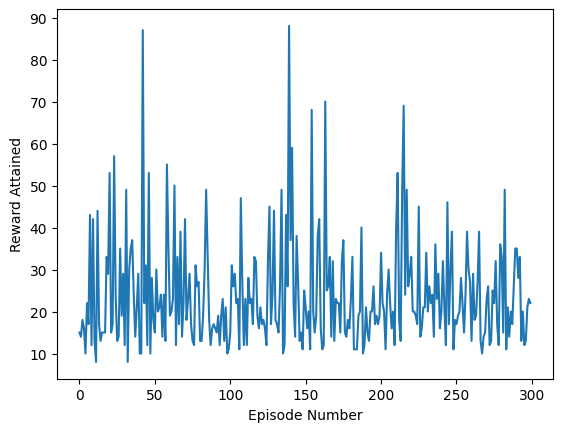

In [7]:
from matplotlib import pyplot as plt
plt.plot(np.arange(n_episodes),max_rewards)
plt.xlabel('Episode Number')
plt.ylabel('Reward Attained')

In [8]:
np.mean(max_rewards)

23.833333333333332

# Basic Q-Learning Agent

In [3]:
# I consulted https://medium.com/swlh/using-q-learning-for-openais-cartpole-v1-4a216ef237df

import numpy as np

# Discretizing the state space (notice pole angle + velocity are more split up since they are more important)
state_space_dims = np.array([30, 30, 50, 50]) # CAN BE CHANGED

# TODO: Play around with this, and variable sized bins, etc...
def get_discrete_state(state, state_space_dims):
    # Cart position is in [-4.8,4.8], we want it in 0,1,2,...N-1
    discrete_cart_position = np.floor((state[0]+4.8) * state_space_dims[0]/9.6)
    # Cart velocity is in [-inf,inf] we want it in 0,1,2,....N-1
    # Since it is usually between [-2,2] we allocated N-2 bins to these, and 2 bins to the outliers
    if (state[1] < -2):
        discrete_cart_velocity = 0
    elif (state[1] > 2):
        discrete_cart_velocity = state_space_dims[1]-1
    else:
        discrete_cart_velocity = (np.floor((state[1]+2) * (state_space_dims[1]-2)/4))+1
    # Pole position is in [-.2095, .2095] most often, we want it in 0,1,2,...,N-1
    if (state[2] < -.2095):
        discrete_pole_position = 0
    elif (state[2] > .2095):
        discrete_pole_position = state_space_dims[2]-1
    else:
        discrete_pole_position = (np.floor((state[2]+.2095) * (state_space_dims[2]-2)/(.2095*2)))+1
    # Pole velocity is in [-inf,inf] we want it in 0,1,2,....N-1
    # Since it is usually between [-3.5,3.5] we allocated N-2 bins to these, and 2 bins to the outliers
    if (state[3] < -3.5):
        discrete_pole_velocity = 0
    elif (state[3] > 3.5):
        discrete_pole_velocity = state_space_dims[3]-1
    else:
        discrete_pole_velocity = (np.floor((state[3]+3.5) * (state_space_dims[2]-2)/7))+1

    discrete_state = np.array([discrete_cart_position,discrete_cart_velocity,discrete_pole_position,discrete_pole_velocity])
    return tuple(discrete_state.astype(int))

class QLearningAgent:
    
    LEARNING_RATE = 0
    DISCOUNT = 0
    
    def __init__(self, learning_rate, discount, curr_state):
        self.LEARNING_RATE = learning_rate
        self.DISCOUNT = discount
        self.q_table = np.random.uniform(low=0, high=1, size=(numpy.append(state_space_dims, env.action_space.n)))
        self.curr_state = curr_state
    
    def act_coord(self, curr_state):
        return np.argmax(self.q_table[curr_state])
    
    def act_rand(self):
        return np.random.randint(0, env.action_space.n)
    
    def update(self, old_state, action, new_state, reward):
        max_future_q = np.max(self.q_table[new_state])
        current_q = self.q_table[old_state+(action,)]
        new_q = current_q + self.LEARNING_RATE * (reward + self.DISCOUNT * max_future_q - current_q)
        self.q_table[old_state+(action,)] = new_q

## Training

In [4]:
agent = QLearningAgent(0.5, 0.95, get_discrete_state(env.reset(), state_space_dims))

n_seasons = 100
n_episodes = 20
max_episode_len = 200
max_rewards = np.zeros(n_seasons)

epsilon = 1
# epsilon_decay = 0.05**(1/(n_episodes*n_seasons/2))
epsilon_decay = 0.9995

for j in range(1, n_seasons + 1): 
    for i in range(1, n_episodes + 1):
        
#         Annealing the learning rate (comment this and set top line LR to 0.1 to remove)
        if ((j-1)*n_episodes+i == 50):
            agent.LEARNING_RATE = 0.3
        elif((j-1)*n_episodes+i == 100):
            agent.LEARNING_RATE = 0.2
        elif((j-1)*n_episodes+i == 150):
            agent.LEARNING_RATE = 0.5
            
        obs = env.reset()
        obs = get_discrete_state(obs,state_space_dims)
        R = 0  # return (sum of rewards)
        t = 0  # time step
        while True:

            # Decide the action
            old_obs = obs
            if (np.random.random() > epsilon):
                action = agent.act_coord(obs)
            else: 
                action = agent.act_rand()
            # Take the action         
            obs, reward, done, _ = env.step(action)
            obs = get_discrete_state(obs,state_space_dims)
            # Update from the action
            if not done:
                agent.update(old_obs, action, obs,reward)

            # Update epsilon after half the episodes
            if (epsilon > 0.05 and ((j-1)*n_episodes+i > 1500)):
                epsilon = epsilon * epsilon_decay

            # Uncomment to watch the behavior in a GUI window
            if (i == -1):
                clear_output(wait=True)
                plt.imshow( env.render(mode='rgb_array') )
                text = "push left" if action == 0 else "push right"
                plt.xlabel(text)
                iteration_text = "Iteration " + str((j-1)*n_episodes+i)
                plt.ylabel(iteration_text)
                score_text = "Score: " + str(R)
                plt.text(5,20,score_text)
                done_text = "DONE" if done else ""
                plt.text(5,40,done_text,color="red")
                plt.show()
                
            R += reward
            
            t += 1
            reset = t == max_episode_len
            if done or reset:
                break
        
        if (R > max_rewards[j-1]): 
            max_rewards[j-1] = R
        if i % (n_episodes/4) == 0:
            print('season', j, ' episode:', i, ' max R for season:', max_rewards[j-1])
    
print('Finished.')

season 1  episode: 5  max R for season: 23.0
season 1  episode: 10  max R for season: 42.0
season 1  episode: 15  max R for season: 42.0
season 1  episode: 20  max R for season: 42.0
season 2  episode: 5  max R for season: 32.0
season 2  episode: 10  max R for season: 64.0
season 2  episode: 15  max R for season: 64.0
season 2  episode: 20  max R for season: 75.0
season 3  episode: 5  max R for season: 36.0
season 3  episode: 10  max R for season: 45.0
season 3  episode: 15  max R for season: 45.0
season 3  episode: 20  max R for season: 45.0
season 4  episode: 5  max R for season: 40.0
season 4  episode: 10  max R for season: 40.0
season 4  episode: 15  max R for season: 51.0
season 4  episode: 20  max R for season: 51.0
season 5  episode: 5  max R for season: 58.0
season 5  episode: 10  max R for season: 58.0
season 5  episode: 15  max R for season: 58.0
season 5  episode: 20  max R for season: 58.0
season 6  episode: 5  max R for season: 35.0
season 6  episode: 10  max R for season:

season 45  episode: 20  max R for season: 38.0
season 46  episode: 5  max R for season: 57.0
season 46  episode: 10  max R for season: 57.0
season 46  episode: 15  max R for season: 57.0
season 46  episode: 20  max R for season: 57.0
season 47  episode: 5  max R for season: 59.0
season 47  episode: 10  max R for season: 59.0
season 47  episode: 15  max R for season: 59.0
season 47  episode: 20  max R for season: 59.0
season 48  episode: 5  max R for season: 35.0
season 48  episode: 10  max R for season: 35.0
season 48  episode: 15  max R for season: 35.0
season 48  episode: 20  max R for season: 35.0
season 49  episode: 5  max R for season: 32.0
season 49  episode: 10  max R for season: 32.0
season 49  episode: 15  max R for season: 32.0
season 49  episode: 20  max R for season: 32.0
season 50  episode: 5  max R for season: 41.0
season 50  episode: 10  max R for season: 53.0
season 50  episode: 15  max R for season: 53.0
season 50  episode: 20  max R for season: 53.0
season 51  episode

season 90  episode: 5  max R for season: 105.0
season 90  episode: 10  max R for season: 108.0
season 90  episode: 15  max R for season: 108.0
season 90  episode: 20  max R for season: 200.0
season 91  episode: 5  max R for season: 162.0
season 91  episode: 10  max R for season: 162.0
season 91  episode: 15  max R for season: 162.0
season 91  episode: 20  max R for season: 162.0
season 92  episode: 5  max R for season: 84.0
season 92  episode: 10  max R for season: 196.0
season 92  episode: 15  max R for season: 196.0
season 92  episode: 20  max R for season: 200.0
season 93  episode: 5  max R for season: 70.0
season 93  episode: 10  max R for season: 87.0
season 93  episode: 15  max R for season: 148.0
season 93  episode: 20  max R for season: 200.0
season 94  episode: 5  max R for season: 148.0
season 94  episode: 10  max R for season: 165.0
season 94  episode: 15  max R for season: 184.0
season 94  episode: 20  max R for season: 184.0
season 95  episode: 5  max R for season: 69.0
se

## Testing

In [5]:
NUM_TESTING_EPISODES = 2000

testing_rewards = np.zeros(NUM_TESTING_EPISODES)

for i in range(NUM_TESTING_EPISODES):
    obs = env.reset()
    obs = get_discrete_state(obs,state_space_dims)
    R = 0
    t = 0
    while True:
        # Uncomment to watch the behavior in a GUI window
        # env.render()
        action = agent.act_coord(obs)
        obs, r, done, _ = env.step(action)
        obs = get_discrete_state(obs,state_space_dims)
        R += r
        t += 1
        reset = t == 500
        if done or reset:
            break
    if(i % (NUM_TESTING_EPISODES/10) == 0):
        print('evaluation episode:', i, 'R:', R)
    testing_rewards[i] = R

NameError: name 'np' is not defined

# Visualize

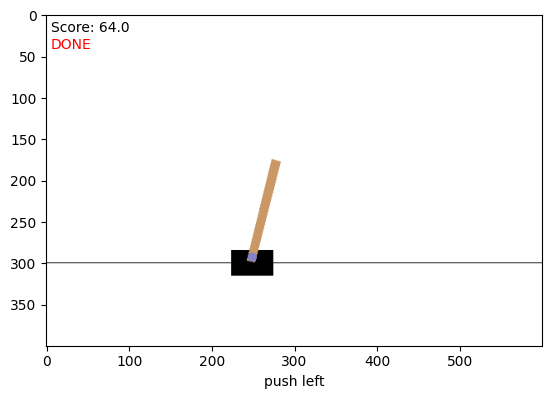

evaluation episode: 1999 R: 65.0


In [398]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

obs = env.reset()
obs = get_discrete_state(obs,state_space_dims)
R = 0
t = 0
while True:
    
    action = agent.act_coord(obs)
    obs, r, done, _ = env.step(action)
    obs = get_discrete_state(obs,state_space_dims)
    
     # Uncomment to watch the behavior in a GUI window
    clear_output(wait=True)
    plt.imshow( env.render(mode='rgb_array') )
    text = "push left" if action == 0 else "push right"
    plt.xlabel(text)
    score_text = "Score: " + str(R)
    plt.text(5,20,score_text)
    done_text = "DONE" if done else ""
    plt.text(5,40,done_text,color="red")
    plt.show()
    
    R += r
    t += 1
    reset = t == 2000
    if done or reset:
        break
print('evaluation episode:', i, 'R:', R)
testing_rewards[i] = R

## Plots

Text(0.5, 1.0, 'Reward Attained over Training Episodes (n = 2000)')

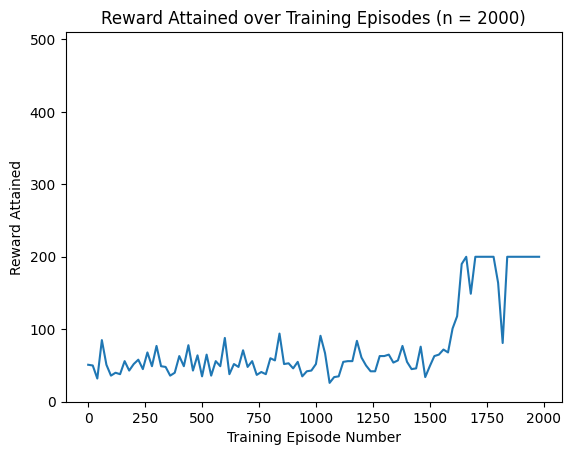

In [394]:
from matplotlib import pyplot as plt
plt.plot(np.arange(n_seasons)*n_episodes,max_rewards)
plt.xlabel('Training Episode Number')
plt.ylabel('Reward Attained')

ax = plt.gca()
ax.set_ylim([0, 510])

plt.title('Reward Attained over Training Episodes (n = 2000)')

Peak 27.746746746746744
Mean 109.499


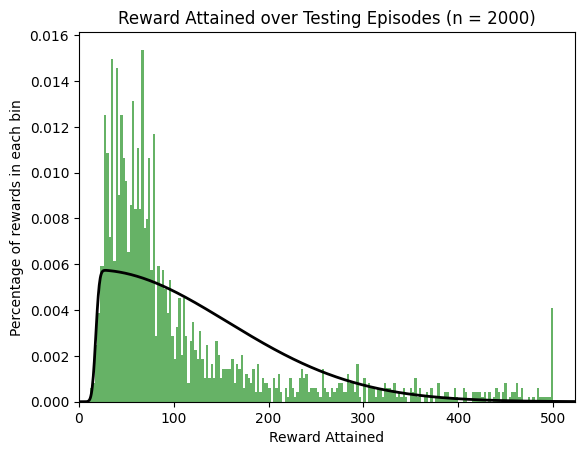

In [395]:
from matplotlib import pyplot as plt
from scipy import stats

testing_rewards = np.sort(testing_rewards)
plt.hist(testing_rewards,bins=200, density=True, alpha=0.6, color='g')
params = stats.skewnorm.fit(testing_rewards)

ax = plt.gca()
ax.set_xlim([0, 523])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = stats.skewnorm.pdf(x,params[0],params[1],params[2])
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel("Reward Attained")
plt.ylabel("Percentage of rewards in each bin")
plt.title("Reward Attained over Testing Episodes (n = 2000)")
print("Peak", x[np.argmax(p)])
print("Mean", np.mean(testing_rewards))

31.142

# Testing Zone

In [ ]:
test=  np.array([0, 1 ,  0.08,  1])
state_space_dims = np.array([30, 30, 50, 50]) # CAN BE CHANGED
get_discrete_state(test, state_space_dims)

In [ ]:
c_velocity = np.zeros(10000)
p_velocity = np.zeros(10000)

In [ ]:
from matplotlib import pyplot as plt
plt.hist(c_velocity)
plt.title("Cart Velocity Histogram on SBTDegenAgent")

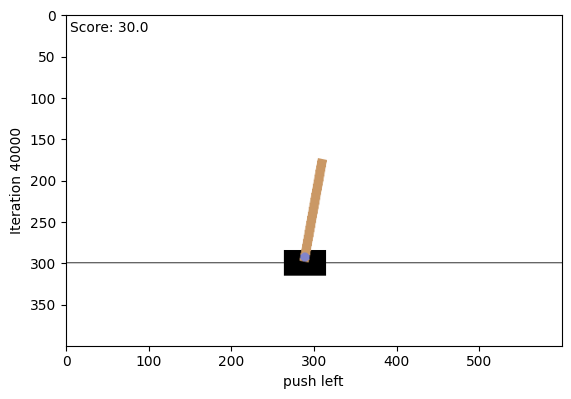

KeyboardInterrupt: 

In [360]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

agent = QLearningAgent(0.5, 0.95, get_discrete_state(env.reset(), state_space_dims))


# Setting q_table to always go left
agent.q_table[:,:,:,:,1] = 0.02
agent.q_table[:,:,:,:,0] = 0.01

max_rewards = np.zeros(100000)
counter = 0

epsilon = 0.9
R = 0
max_R = 0
R_last = False

while (R < 200 or R_last == False): 
    if (R >= 200):
        R_last = True
    obs = env.reset()
    obs = get_discrete_state(obs,state_space_dims)
    t = 0  # time step
    R = 0  # reward
    while True:
        if (counter % 10000 == 0):
             # Uncomment to watch the behavior in a GUI window
            clear_output(wait=True)
            plt.imshow( env.render(mode='rgb_array') )
            text = "push left" if action == 0 else "push right"
            plt.xlabel(text)
            iteration_text = "Iteration " + str(counter)
            plt.ylabel(iteration_text)
            score_text = "Score: " + str(R)
            plt.text(5,20,score_text)
            done_text = "DONE" if done else ""
            plt.text(5,40,done_text,color="red")
            plt.show()

        # Decide the action
        old_obs = obs
        if (np.random.random() > epsilon):
            action = agent.act_coord(obs)
        else: 
            action = agent.act_rand()
        # Take the action         
        obs, reward, done, _ = env.step(action)
        obs = get_discrete_state(obs,state_space_dims)
        # Update from the action
        if not done:
            agent.update(old_obs, action, obs,reward)

        R += reward
        
        t += 1
        reset = t == max_episode_len
        if done or reset:
            break

    max_rewards[counter] = R
    if counter % 100 == -1:
        print('Episode', counter, ' R :', max_rewards[counter])
    counter = counter+1
    
print('Finished.')
print(R)